# User Guide

This notebook walks through how to use the Datawaza functions for data exploration, cleaning and modeling. It doesn't cover everything you need to do in a typical project. It just shows how you might incorporate the Datawaza functions into your existing workflow. 

## Table of Contents

* **[Explore](#Explore)**
    * [Import Libraries](#Import-Libraries)
    * [Load Data](#Load-Data)
    * [Get Outliers](#Get-Outliers) - *get_outliers()*
    * [Get Unique Values](#Get-Unique-Values) - *get_unique()*
    * [Plot Charts](#Plot-Charts) - *plot_charts()*
        * [Categorical Distributions](#Categorical-Distributions)
        * [Continuous Distributions](#Continuous-Distributions)
    * [Load Encoded Data](#Load-Encoded-Data)
    * [Get Correlations](#Get-Correlations) - *get_corr()*
        * [Top Correlations](#Top-Correlations)
        * [Top Correlations with Target](#Top-Correlations-with-Target)
        * [Create DataFrame of Top Correlated Features](#Create-DataFrame-of-Top-Correlated-Features)
    * [Plot Correlations](#Plot-Correlations) - *plot_corr()*
* **[Clean](#Clean)**
    * [Convert Data Types](#Convert-Data-Types) - *convert_dtypes()*
    * [Load Data Units and Time Data](#Load-Data-Units-and-Time-Data)
    * [Convert Data Values](#Convert-Data-Values) - *convert_data_values()*
    * [Convert Time Values](#Convert-Time-Values) - *convert_time_values()*
    * [Reduce Multicollinearity](#Reduce-Multicollinearity) - *reduce_multicollinearity()*
* **[Tools](#Tools)**
    * [Check for Duplicates](#Check-for-Duplicates) - *check_for_duplicates()*

---
## Explore

The `dw.explore` module provides tools to streamline exploratory data analysis.
It contains functions to find unique values, plot distributions, detect outliers,
extract the top correlations, and plot correlations.

* [Import Libraries](#Import-Libraries)
* [Load Data](#Load-Data)
* [Get Outliers](#Get-Outliers) - *get_outliers()*
* [Get Unique Values](#Get-Unique-Values) - *get_unique()*
* [Plot Charts](#Plot-Charts) - *plot_charts()*
    * [Categorical Distributions](#Categorical-Distributions)
    * [Continuous Distributions](#Continuous-Distributions)
* [Load Encoded Data](#Load-Encoded-Data)
* [Get Correlations](#Get-Correlations) - *get_corr()*
    * [Top Correlations](#Top-Correlations)
    * [Top Correlations with Target](#Top-Correlations-with-Target)
    * [Create DataFrame of Top Correlated Features](#Create-DataFrame-of-Top-Correlated-Features)
* [Plot Correlations](#Plot-Correlations) - *plot_corr()*

### Import Libraries

In addition to the usual libraries, import `datawaza` as `dw`

In [1]:
# Import the libraries
import numpy as np
import pandas as pd
import datawaza as dw

### Load Data

Let's load some initial data and set some display preferences.

In [2]:
# Read in the data in CSV format
df = pd.read_csv('data/bank-additional-full.csv', sep=';')

In [3]:
# Set some display preferences
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# Show the first few records of data
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Examine the data types and null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [6]:
# Create some column lists we can use to target the right kind of variables
all_columns = list(df.columns)
num_columns = [col for col in all_columns if df[col].dtype in ['int64', 'float64']]
cat_columns = [col for col in all_columns if df[col].dtype in ['object', 'category', 'string']]

### Get Outliers

`dw.get_outliers()` detects and summarizes outliers for the specified numeric columns in a
    DataFrame, based on an IQR ratio.

This function identifies outliers using Tukey's method, where outliers are considered to be those data points
that fall below Q1 - `ratio` * IQR or above Q3 + `ratio` * IQR. You can exclude zeros from the calculations,
as they can appear as outliers and skew your results. You can also change the default IQR `ratio` of  1.5.
If outliers are found, they will be summarized in the returned DataFrame. In addition, the distributions of
the variables with outliers can be plotted as boxplots.

Use this function to identify outliers during the early stages of exploratory
    data analysis. With one line, you can see: total non-null, total zero values,
    zero percent, outlier count, outlier percent, skewness, and kurtosis. You can
    also visually spot outliers outside of the whiskers in the boxplots. Then you
    can decide how you want to handle the outliers (ex: log transform, drop, etc.)

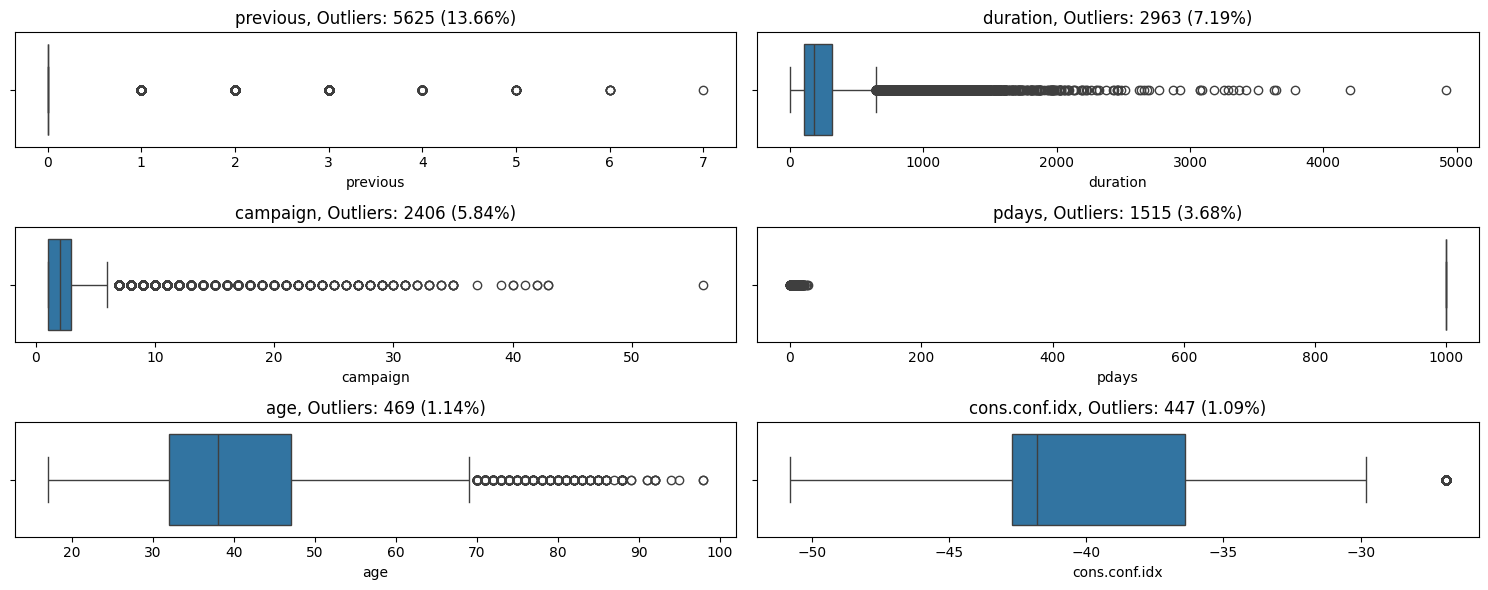

In [7]:
# Identify outliers, store in dataframe, and plot boxplots
outliers_df = dw.get_outliers(df, num_columns, plot=True, width=15, height=1)

In [8]:
# Display the dataframe with the output from detect_outliers
outliers_df

,Column,Total Non-Null,Total Zero,Zero Percent,Outlier Count,Outlier Percent,Skewness,Kurtosis
4,previous,41188,35563,86.34,5625,13.66,3.83,20.11
1,duration,41188,4,0.01,2963,7.19,3.26,20.25
2,campaign,41188,0,0.00,2406,5.84,4.76,36.98
3,pdays,41188,15,0.04,1515,3.68,-4.92,22.23
0,age,41188,0,0.00,469,1.14,0.78,0.79
5,cons.conf.idx,41188,0,0.00,447,1.09,0.30,-0.36


### Get Unique Values

`dw.get_unique()` prints the unique values of all variables below a threshold `n`, including
    counts and percentages.

This function examines the unique values of all the variables in a DataFrame. If the number is below
a threshold `n`, it will list their unique values. For each value, it prints out the count and percentage
of the dataset with that value. You can change the sort, and there are options to strip single quotes
from the variable names, or exclude NaN values. You can optionally show descriptive statistics for the
continuous variables able the `n` threshold, or display simple plots.

Use this to quickly examine the features of your dataset at the beginning of
    exploratory data analysis. Use `df.nunique()` to first determine how many unique
    values each variable has, and identify a number that likely separates the
    categorical from continuous numeric variables. Then run get_unique using that
    number as `n` (this avoids iterating over continuous data).

In [9]:
# Look at unique value counts to choose an 'n' threshold between categorical and continuous
df.nunique().sort_values(ascending=False)

duration          1544
euribor3m          316
age                 78
campaign            42
pdays               27
cons.conf.idx       26
cons.price.idx      26
job                 12
nr.employed         11
month               10
emp.var.rate        10
previous             8
education            8
day_of_week          5
marital              4
default              3
poutcome             3
loan                 3
housing              3
contact              2
y                    2
dtype: int64

In [10]:
# Show the unique values of each variable below the threshold of n = 12
dw.get_unique(df, 12, count=True, percent=True)


CATEGORICAL: Variables with unique values equal to or below: 12

job has 12 unique values:

    admin.              10422   25.3%
    blue-collar         9254    22.47%
    technician          6743    16.37%
    services            3969    9.64%
    management          2924    7.1%
    retired             1720    4.18%
    entrepreneur        1456    3.54%
    self-employed       1421    3.45%
    housemaid           1060    2.57%
    unemployed          1014    2.46%
    student             875     2.12%
    unknown             330     0.8%

marital has 4 unique values:

    married        24928   60.52%
    single         11568   28.09%
    divorced       4612    11.2%
    unknown        80      0.19%

education has 8 unique values:

    university.degree         12168   29.54%
    high.school               9515    23.1%
    basic.9y                  6045    14.68%
    professional.course       5243    12.73%
    basic.4y                  4176    10.14%
    basic.6y                 

### Plot Charts

`dw.plot_charts` displays multiple bar plots and histograms for categorical and/or continuous
    variables in a DataFrame, with an option to dimension by the specified `hue`.

This function allows you to plot a large number of distributions with one line of code. You choose which type of plots to create by setting `plot_type` to `cat`, `cont`, or `both`. Categorical variables are plotted with `sns.countplot` ordered by descending value counts for a clean appearance. Continuous variables are plotted with `sns.histplot`. There are two approaches to identifying categorical vs. continuous variables: (a) you can specify `cat_cols` and `cont_cols` as lists of the respective column names, or (b) you can specify `n` as the dividing line, and any variable with `n` or lower unique values will be treated as categorical. In addition, you can enable `dtype_check` on the continuous columns to only include columns of data type `int64` or `float64`.

For each type of variable, it creates a subplot layout that has `ncols`
    columns, and is `fig_width` wide. It calculates how many rows are required to
    display all the plots, and each row is `subplot_height` high. Specify `hue` if
    you want to dimension the plots by another variable. You can set
    `color_discrete_map` to a color mapping dictionary for the values of the `hue`
    variable. You can also customize some parameters of the plots, such as
    `rotation` of the X axis tick labels. For categorical variables, you can
    normalize the plots to show proportions instead of counts by setting
    `normalize` to True.

For histograms, you can display KDE lines with `kde`, and change how the `hue`
    variable appears by setting `multiple`. If you have a large amount of data that
    is taking too long to process, you can take a random sample of your data by
    setting `sample_size` to either a count or proportion. To handle skewed data,
    you have two options: (a) you can enable log scale on the X axis with
    `log_scale`, and (b) you can ignore zero values with `ignore_zero` (these can
    sometimes dominate the left end of a chart).

Use this function to quickly visualize the distributions of your data during
    exploratory data analysis. With one line, you can produce a comprehensive
    series of plots that can help you spot issues that will require handling during
    data cleaning. By setting `hue` to your target y variable, you might be able to
    catch glimpses of potential correlations or relationships.

#### Categorical Distributions

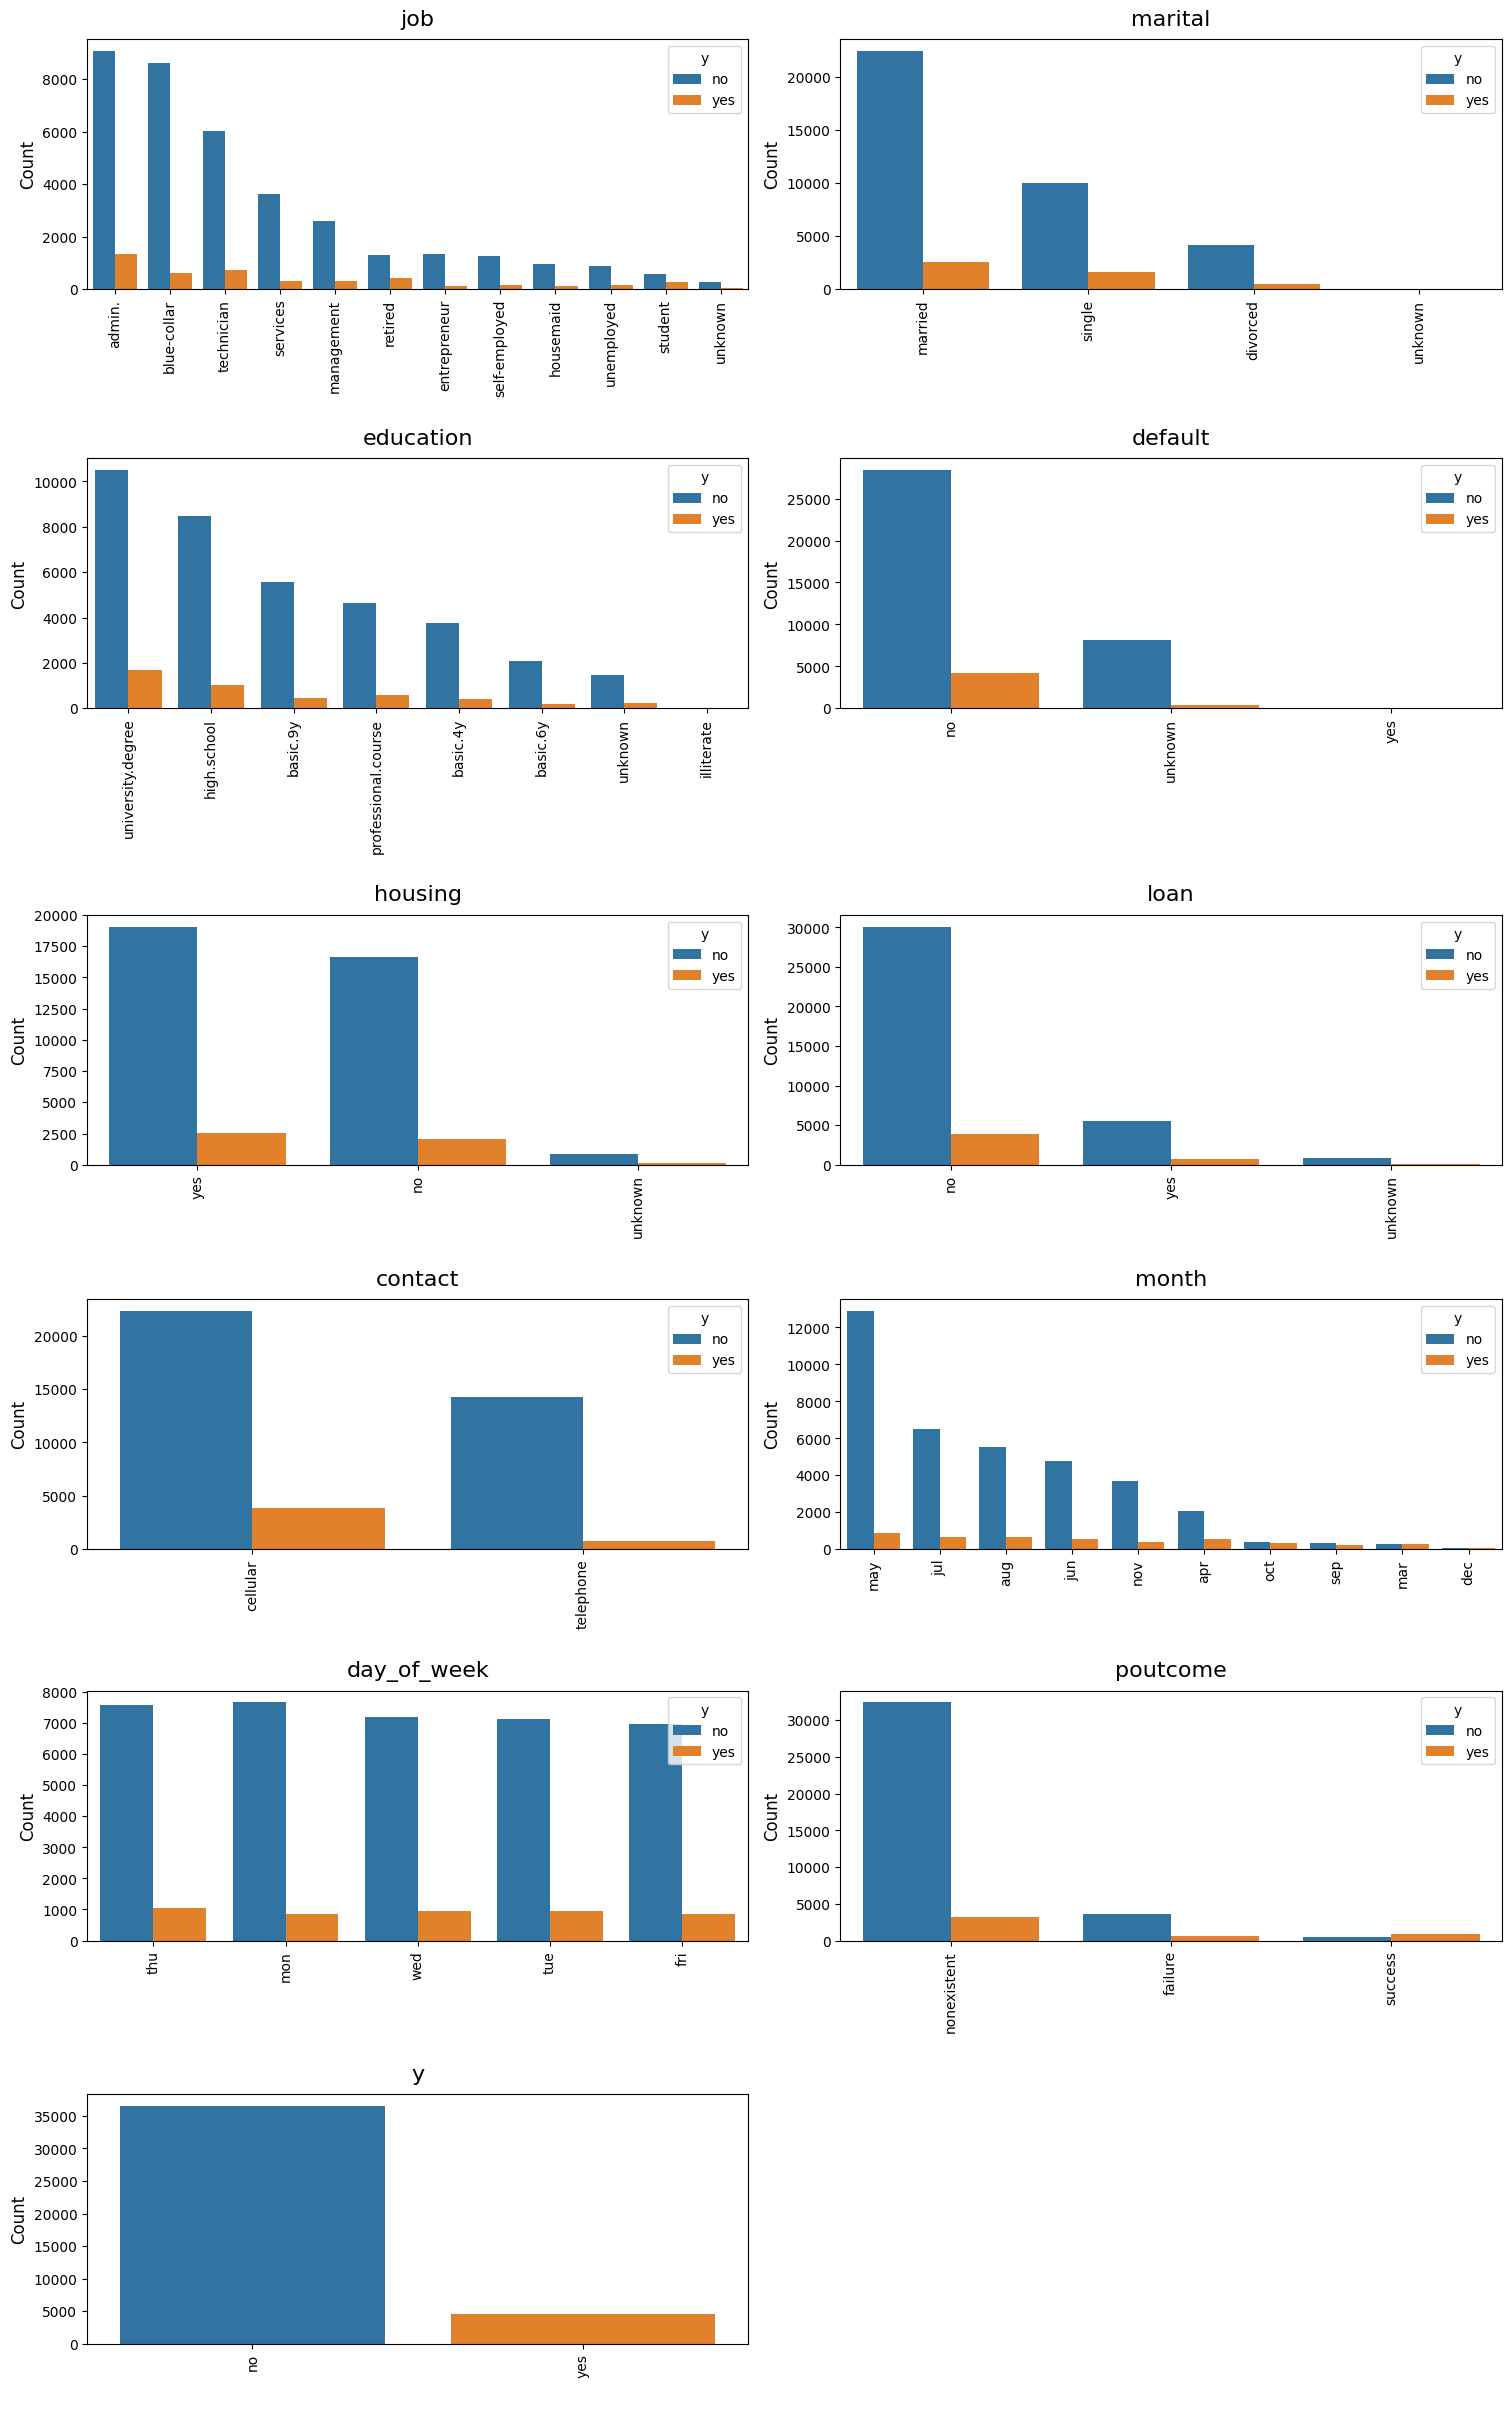

In [11]:
# Plot bar charts of categorical variables, dimensioned by the target variable
dw.plot_charts(df, plot_type='cat', cat_cols=cat_columns, hue='y', ncols=2, fig_width=15, rotation=90)

#### Continuous Distributions

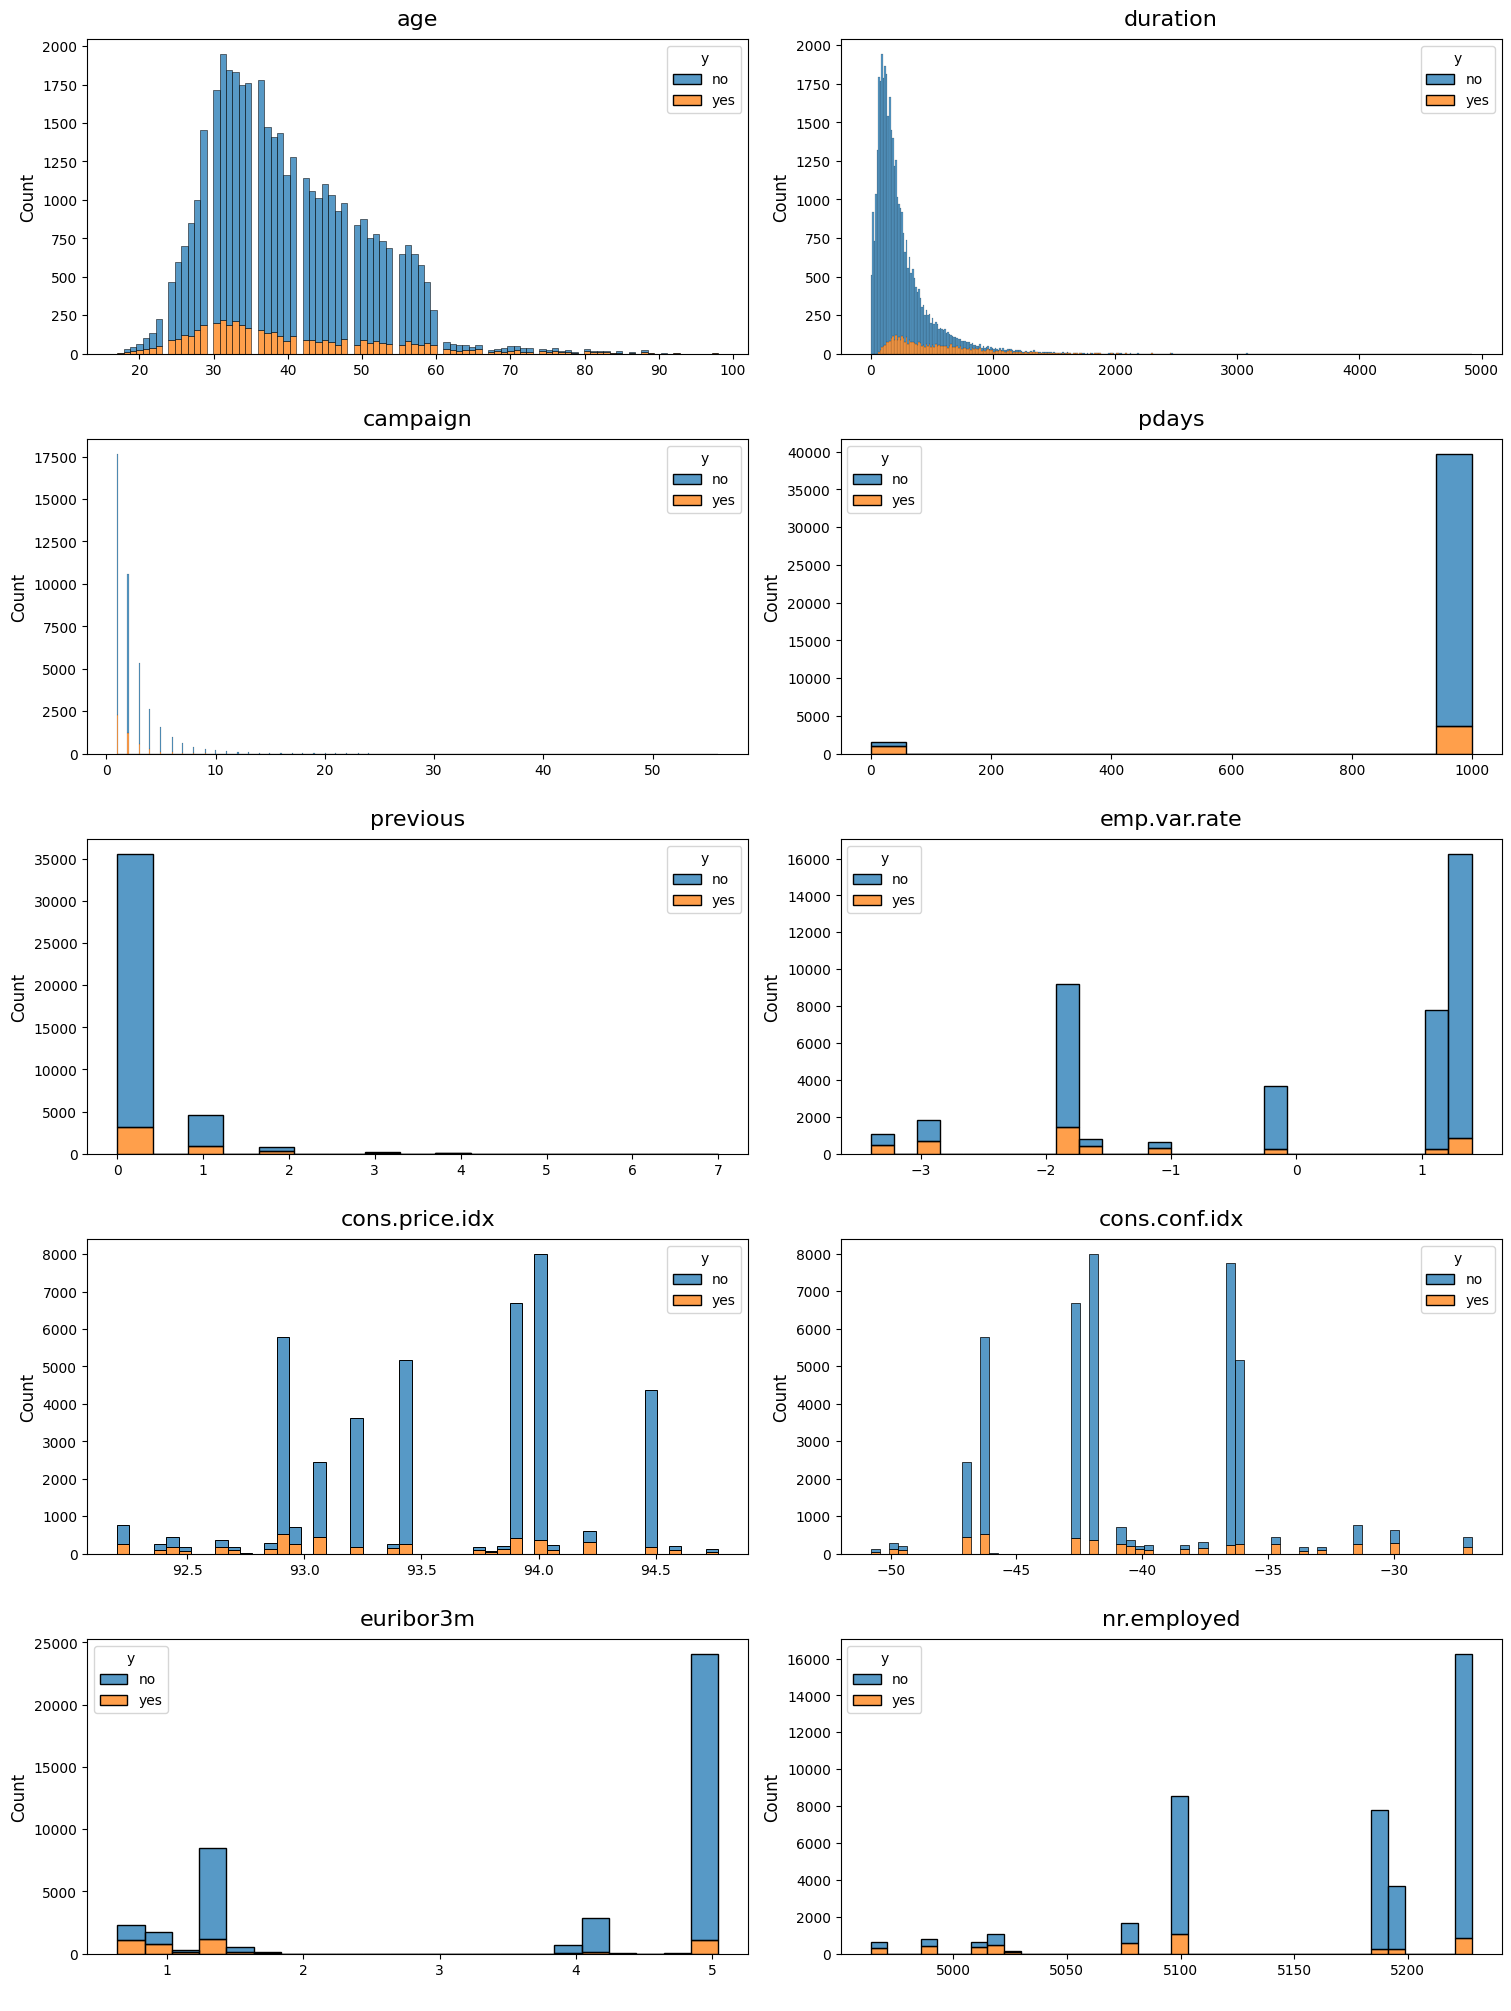

In [12]:
# Plot histograms of continuous variables, dimensioned by the target variable
dw.plot_charts(df, plot_type='cont', cont_cols=num_columns, hue='y', multiple='stack', ncols=2, fig_width=15)

### Load Encoded Data

Let's now load some encoded data, where everything is numeric, so we can demonstrate the correlation functions.

In [13]:
# Load a previously cleaned and encoded dataset (processing not shown here)
df_enc = pd.read_csv('data/df_enc.csv')
df_enc.drop(['subscribed'], axis=1, inplace=True)

In [14]:
df_enc.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,previously_contacted,subscribed_enc,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,no_default_1,housing_yes,loan_yes,contact_telephone
0,56,261,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
1,57,149,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,37,226,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1
3,40,151,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1
4,56,307,1,0,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1


### Get Correlations

`dw.get_corr()` displays the top `n` positive and negative correlations with a target variable
    in a DataFrame.

This function computes the correlation matrix for the provided DataFrame, and
    identifies the top `n` positively and negatively correlated pairs of variables.
    By default, it prints a summary of these correlations. Optionally, it can
    return arrays of the variable names involved in these top correlations,
    avoiding duplicates.

Use this to quickly identify the strongest correlations with a target variable.
    You can also use this to reduce a DataFrame with a large number of features
    down to just the top `n` correlated features. Extract the names of the top
    correlated features into 2 separate arrays (one for positive, one for
    negative). Concatenate those variable lists and append the target variable. Use
    this concatenated array to create a new DataFrame.

#### Top Correlations

We can start by just listing the top correlations between all variables.

In [15]:
# Show the top positive and negative correlations
dw.get_corr(df_enc, n=20)

Top 20 positive correlations:
                       Variable 1            Variable 2  Correlation
0                    emp.var.rate             euribor3m         0.97
1                       euribor3m           nr.employed         0.95
2                poutcome_success  previously_contacted         0.95
3                    emp.var.rate           nr.employed         0.91
4                           pdays  previously_contacted         0.84
5                  cons.price.idx          emp.var.rate         0.78
6                           pdays      poutcome_success         0.74
7                  cons.price.idx             euribor3m         0.69
8                poutcome_failure              previous         0.68
9                        previous  previously_contacted         0.59
10                 cons.price.idx     contact_telephone         0.59
11               poutcome_success              previous         0.52
12                 cons.price.idx           nr.employed         0.52
13  

<div style="background-color: #e8f3ff; border: 1px solid #aecae8; padding: 10px; border-radius: 3px;">
    <b>Observation:</b> Many of these features are strongly correlated with each other. We'll later use <i>reduce_multicollinearity()</i> to remove one of each pair that's least correlated with the target variable.
</div>

#### Top Correlations with Target

Now let's list and extract the top positive and negative correlations with our target variable.

In [16]:
# Get the top positive and negative correlations with the target variable, and save to lists
pos_features, neg_features = dw.get_corr(df_enc, n=15, var='subscribed_enc', return_arrays=True)

Top 15 positive correlations:
              Variable 1      Variable 2  Correlation
0               duration  subscribed_enc         0.41
1       poutcome_success  subscribed_enc         0.32
2   previously_contacted  subscribed_enc         0.32
3                  pdays  subscribed_enc         0.27
4               previous  subscribed_enc         0.23
5              month_mar  subscribed_enc         0.14
6              month_oct  subscribed_enc         0.14
7              month_sep  subscribed_enc         0.12
8           no_default_1  subscribed_enc         0.10
9            job_student  subscribed_enc         0.09
10           job_retired  subscribed_enc         0.09
11             month_dec  subscribed_enc         0.08
12             month_apr  subscribed_enc         0.08
13         cons.conf.idx  subscribed_enc         0.06
14        marital_single  subscribed_enc         0.05

Top 15 negative correlations:
              Variable 1      Variable 2  Correlation
0            nr.emplo

#### Create DataFrame of Top Correlated Features

We can now create a new DataFrame that consists only of our top positive and negative features. However, it would be better to reduce multicollinearity first. See [Reduce Multicollinearity](#Reduce-Multicollinearity).

In [17]:
print("Top positive correlation features:\n", pos_features)
print("\nTop negative correlation features:\n", neg_features)

Top positive correlation features:
 ['duration' 'poutcome_success' 'previously_contacted' 'pdays' 'previous'
 'month_mar' 'month_oct' 'month_sep' 'no_default_1' 'job_student'
 'job_retired' 'month_dec' 'month_apr' 'cons.conf.idx' 'marital_single']

Top negative correlation features:
 ['nr.employed' 'euribor3m' 'emp.var.rate' 'poutcome_nonexistent'
 'contact_telephone' 'cons.price.idx' 'month_may' 'campaign'
 'job_blue-collar' 'education_basic.9y' 'marital_married' 'month_jul'
 'job_services' 'job_entrepreneur' 'day_of_week_mon']


In [18]:
# Combine them together and add the target variable
top_features = np.concatenate((pos_features, neg_features))
top_features = np.concatenate((top_features, ['subscribed_enc']))

In [19]:
# Create a dataframe with just these columns
df_top_features = pd.DataFrame.copy(df_enc[top_features])

In [20]:
# Review the top features dataframe
df_top_features

,duration,poutcome_success,previously_contacted,pdays,previous,month_mar,month_oct,month_sep,no_default_1,job_student,job_retired,month_dec,month_apr,cons.conf.idx,marital_single,nr.employed,euribor3m,emp.var.rate,poutcome_nonexistent,contact_telephone,cons.price.idx,month_may,campaign,job_blue-collar,education_basic.9y,marital_married,month_jul,job_services,job_entrepreneur,day_of_week_mon,subscribed_enc
0,261,0,0,0,0,0,0,0,1,0,0,0,0,-36.4,0,5191.0,4.857,1.1,1,1,93.994,1,1,0,0,1,0,0,0,1,0
1,149,0,0,0,0,0,0,0,0,0,0,0,0,-36.4,0,5191.0,4.857,1.1,1,1,93.994,1,1,0,0,1,0,1,0,1,0
2,226,0,0,0,0,0,0,0,1,0,0,0,0,-36.4,0,5191.0,4.857,1.1,1,1,93.994,1,1,0,0,1,0,1,0,1,0
3,151,0,0,0,0,0,0,0,1,0,0,0,0,-36.4,0,5191.0,4.857,1.1,1,1,93.994,1,1,0,0,1,0,0,0,1,0
4,307,0,0,0,0,0,0,0,1,0,0,0,0,-36.4,0,5191.0,4.857,1.1,1,1,93.994,1,1,0,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40190,334,0,0,0,0,0,0,0,1,0,1,0,0,-50.8,0,4963.6,1.028,-1.1,1,0,94.767,0,1,0,0,1,0,0,0,0,1
40191,383,0,0,0,0,0,0,0,1,0,0,0,0,-50.8,0,4963.6,1.028,-1.1,1,0,94.767,0,1,1,0,1,0,0,0,0,0
40192,189,0,0,0,0,0,0,0,1,0,1,0,0,-50.8,0,4963.6,1.028,-1.1,1,0,94.767,0,2,0,0,1,0,0,0,0,0
40193,442,0,0,0,0,0,0,0,1,0,0,0,0,-50.8,0,4963.6,1.028,-1.1,1,0,94.767,0,1,0,0,1,0,0,0,0,1


### Plot Correlations

`dw.plot_corr()` plots the top `n` correlations of one variable against others in a DataFrame.

This function generates a barplot that visually represents the correlations of
    a specified column with other numeric columns in a DataFrame. It displays both
    the strength (height of the bars) and the nature (color) of the correlations
    (positive or negative). The function computes correlations using the specified
    method and presents the strongest positive and negative correlations up to the
    number specified by `n`. Correlations are ordered from strongest to lowest,
    from the outside in.

Use this to communicate the correlations of one particular variable (ex: target
    y) in relation to others with a very clean design. It's much easier to scan
    this correlation chart vs. trying to find the variable of interest in a
    heatmap. The fixed Y axis scales, and Red-Yellow-Green color palette, ensure
    the actual magnitudes of the positive or negative correlations are clear and
    not misinterpreted.

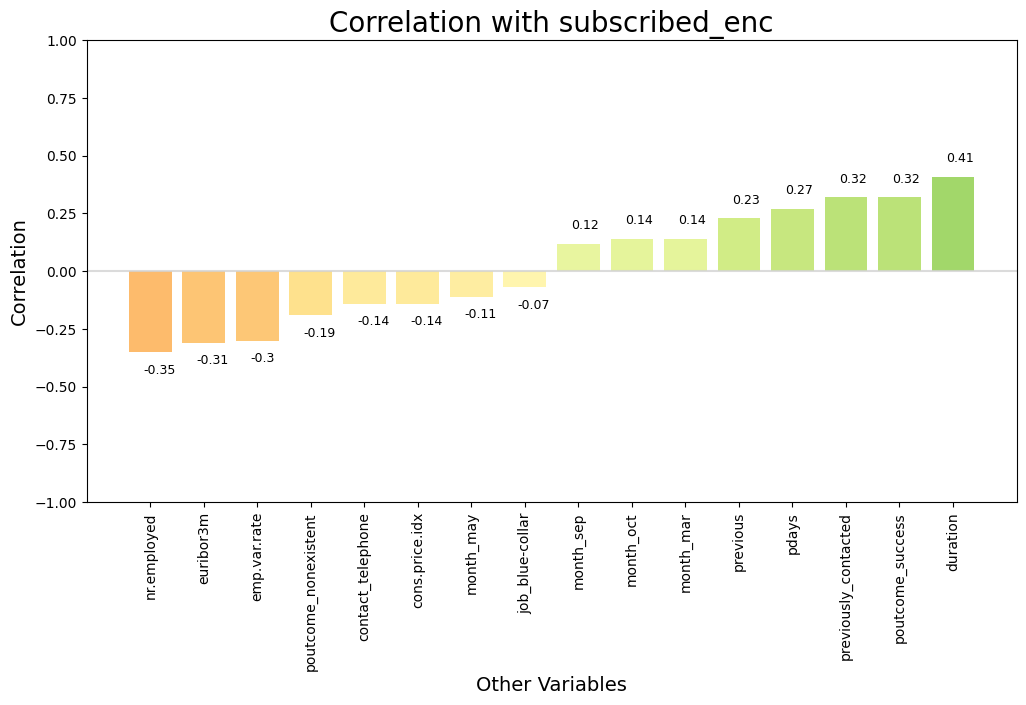

In [21]:
# Plot a chart showing the top correlations with target variable
dw.plot_corr(df_enc, 'subscribed_enc', n=16, size=(12,6), rotation=90)

---
## Clean

The `dw.clean` module provides tools to clean data in preparation for modeling.
It contains functions to convert data types, convert unites of measurement,
convert time values, and reduce multicollinearity.

* [Convert Data Types](#Convert-Data-Types) - *convert_dtypes()*
* [Load Data Units and Time Data](#Load-Data-Units-and-Time-Data)
* [Convert Data Values](#Convert-Data-Values) - *convert_data_values()*
* [Convert Time Values](#Convert-Time-Values) - *convert_time_values()*
* [Reduce Multicollinearity](#Reduce-Multicollinearity) - *reduce_multicollinearity()*

### Convert Data Types

`dw.conver_dtypes()` converts specified columns in a DataFrame to the desired data type.

This function converts the data type of the specified columns in the input
DataFrame to the desired target data type. It supports both base Python data
types (e.g., int, float, str) and Pandas-specific data types (e.g., 'int64',
'float64', 'object', 'bool', 'datetime64', 'timedelta[ns]', 'category'). If
`inplace` is set to True (default), the conversion is done in place, modifying
the original DataFrame. If `inplace` is False, a new DataFrame with the
converted columns is returned. If `show_results` is set to True, it will print
the results of each successful conversion and any error messages for columns
that could not be converted.

Use this function when you need to convert the data types of specific columns
in a DataFrame to a consistent target data type, especially when dealing with
multiple columns at once and identifying columns that require further data
cleaning.

In [22]:
# Review data types of our previously identified categorical features
df[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   job          41188 non-null  object
 1   marital      41188 non-null  object
 2   education    41188 non-null  object
 3   default      41188 non-null  object
 4   housing      41188 non-null  object
 5   loan         41188 non-null  object
 6   contact      41188 non-null  object
 7   month        41188 non-null  object
 8   day_of_week  41188 non-null  object
 9   poutcome     41188 non-null  object
 10  y            41188 non-null  object
dtypes: object(11)
memory usage: 3.5+ MB


In [23]:
# Review data types of our previously identified numeric features
df[num_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   duration        41188 non-null  int64  
 2   campaign        41188 non-null  int64  
 3   pdays           41188 non-null  int64  
 4   previous        41188 non-null  int64  
 5   emp.var.rate    41188 non-null  float64
 6   cons.price.idx  41188 non-null  float64
 7   cons.conf.idx   41188 non-null  float64
 8   euribor3m       41188 non-null  float64
 9   nr.employed     41188 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 3.1 MB


In [24]:
# Change all the categorical features to 'category' data type
dw.convert_dtypes(df, cat_columns, 'category')

In [25]:
# Review the updated data types for our categorical features
df[cat_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   job          41188 non-null  category
 1   marital      41188 non-null  category
 2   education    41188 non-null  category
 3   default      41188 non-null  category
 4   housing      41188 non-null  category
 5   loan         41188 non-null  category
 6   contact      41188 non-null  category
 7   month        41188 non-null  category
 8   day_of_week  41188 non-null  category
 9   poutcome     41188 non-null  category
 10  y            41188 non-null  category
dtypes: category(11)
memory usage: 444.9 KB


In [26]:
# Change all the numeric features to 'float' data type
dw.convert_dtypes(df, num_columns, 'float')

In [27]:
# Review the updated data types for our numeric features
df[num_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  float64
 1   duration        41188 non-null  float64
 2   campaign        41188 non-null  float64
 3   pdays           41188 non-null  float64
 4   previous        41188 non-null  float64
 5   emp.var.rate    41188 non-null  float64
 6   cons.price.idx  41188 non-null  float64
 7   cons.conf.idx   41188 non-null  float64
 8   euribor3m       41188 non-null  float64
 9   nr.employed     41188 non-null  float64
dtypes: float64(10)
memory usage: 3.1 MB


### Load Data Units and Time Data

In [28]:
# Load data with mixed data units of measurement, and different date/time formats
df_data_time = pd.read_csv('data/df_data_time.csv').drop(columns='Unnamed: 0')

In [31]:
# Review the messy data that mixes numbers and strings, mixes units of measurement, the incconsistent syntax, NaNs, and 0's
df_data_time[:10]

,A,B,C,D
0,67.12 mB,5.19 GB,45161.23615,2019-09-11
1,117.02mB,2.34 GB,0.00000,2019-07-13
2,39.61 MB,52.94 MB,45161.23608,2021-02-02
3,56.11 giga,7.97 GB,45161.21538,NaN
4,9.84 Gigabytes,26.23 GB,45160.48826,2019-12-23
5,NaN,2.35 GB,45160.78181,NaN
6,14.37 Gb,1.31 TB,45161.23658,2020-09-25
7,63.37mb,2.65 MB,45139.22113,0
8,27.64gb,25.84 GB,NaN,2019-05-18
9,0 B,39.38 GB,45160.64827,NaN


In [32]:
# Review the data types, note the objects and lack of datetime formats
df_data_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       18 non-null     object 
 1   B       19 non-null     object 
 2   C       18 non-null     float64
 3   D       16 non-null     object 
dtypes: float64(1), object(3)
memory usage: 736.0+ bytes


In [33]:
# Crate lists of columns we want to convert
data_columns = ['A', 'B']
time_columns = ['C', 'D']

### Convert Data Values

`dw.convert_data_values()` converts mixed data values (ex: GB, MB, KB) to a common unit of measurement.

This function converts values in the specified columns of the input DataFrame
to the desired target unit. If `inplace` is set to True, the conversion is done
in place, modifying the original DataFrame. If `inplace` is False (default), a
new DataFrame with the converted values is returned. The string suffix is
dropped and the column is converted to a float. It handles inconsistent suffix
strings, with or without spaces after the numbers (ex: '10GB', '10 Gb'). A
variety of spelling options are supported (ex: 'GB', 'Gigabytes'), but you
can pass a custom dictionary as `conversion_dict` if desired. To display a
summary of the changes made, set `show_results` to True.

Use this to clean up messy data that has a variety of units of measurement
appended as text strings to the numeric values. The result will be columns
with a common unit of measurement as floats (with no text suffixes).

In [34]:
# Convert values in specified columns to GB and assign to a new df
df_data = dw.convert_data_values(df_data_time, data_columns, target_unit='GB')

In [35]:
# Review the converted data in the new dataframe
df_data[['A','B']][:10]

,A,B
0,0.065547,5.190000
1,0.114277,2.340000
2,0.038682,0.051699
3,56.110000,7.970000
4,9.840000,26.230000
5,NaN,2.350000
6,14.370000,1341.440000
7,0.061885,0.002588
8,27.640000,25.840000
9,0.000000,39.380000


In [36]:
# Review the converted data, note the dtype is now float
df_data[['A','B']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       18 non-null     float64
 1   B       19 non-null     float64
dtypes: float64(2)
memory usage: 432.0 bytes


In [37]:
# Convert data values to MB in place, modifying the existing df, and show a summary of the changes
dw.convert_data_values(df_data_time, data_columns, target_unit='MB', inplace=True, show_results=True, decimal=8)

Original: 67.12 mB -> Converted: 67.12000000 MB
Original: 117.02mB -> Converted: 117.02000000 MB
Original: 39.61 MB -> Converted: 39.61000000 MB
Original: 56.11 giga -> Converted: 57456.64000000 MB
Original: 9.84 Gigabytes -> Converted: 10076.16000000 MB
Original: NaN -> Converted: NaN
Original: 14.37 Gb -> Converted: 14714.88000000 MB
Original: 63.37mb -> Converted: 63.37000000 MB
Original: 27.64gb -> Converted: 28303.36000000 MB
Original: 0 B -> Converted: 0.00000000 MB
Original: 1.2 GB -> Converted: 1228.80000000 MB
Original: 696.27 Mega -> Converted: 696.27000000 MB
Original: 766.18 Megabytes -> Converted: 766.18000000 MB
Original: 868.81 mega -> Converted: 868.81000000 MB
Original: 0B -> Converted: 0.00000000 MB
Original: 150.35 megabyte -> Converted: 150.35000000 MB
Original: 8.88gigabyte -> Converted: 9093.12000000 MB
Original: 0b -> Converted: 0.00000000 MB
Original: 198.58giga -> Converted: 203345.92000000 MB
Original: 5.19 GB -> Converted: 5314.56000000 MB
Original: 2.34 GB -

### Convert Time Values

`dw.convert_time_values()` converts time values in specified columns of a DataFrame to a target format.

This function converts time values in the specified columns of the input
DataFrame to the desired target format. If `inplace` is set to True, the
conversion is done in place, modifying the original DataFrame. If `inplace`
is False (default), a new DataFrame with the converted values is returned.

The function can handle time values in various formats, including:
1. Excel serial format (e.g., '45161.23458')
2. String format (e.g., 'YYYY-MM-DD')
3. UNIX epoch in milliseconds (e.g., '1640304000000.0')

If your format is not supported, you can define `pattern_list` as a list of
custom datetime patterns.

If `zero_to_nan` is set to True, values of '0', '0.0', '0.00', 0, 0.0, or 0.00
will be replaced with NaN. Otherwise, zero values will be detected as a
Unix Epoch format with value 1970-01-01 00:00:00.

You can use the default `target_format` of '%Y-%m-%d %H:%M:%S', or specify
a different format. To display a summary of the changes made, set
`show_results` to True.

In [38]:
# Convert time values in specified columns to the default format
df_time = dw.convert_time_values(df_data_time, time_columns)

In [39]:
# Review the converted data in the new dataframe, notice the consistent date/time format
df_time[['C','D']][:10]

,C,D
0,2023-08-25 05:40:03,2019-09-11
1,1970-01-01 00:00:00,2019-07-13
2,2023-08-25 05:39:57,2021-02-02
3,2023-08-25 05:10:08,NaT
4,2023-08-24 11:43:05,2019-12-23
5,2023-08-24 18:45:48,NaT
6,2023-08-25 05:40:40,2020-09-25
7,2023-08-03 05:18:25,1970-01-01
8,NaT,2019-05-18
9,2023-08-24 15:33:30,NaT


In [40]:
# Review the converted data, note the dtype is now a pandas datetime object
df_time[['C','D']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   C       18 non-null     datetime64[ns]
 1   D       16 non-null     datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 432.0 bytes


### Reduce Multicollinearity

`dw.reduce_multicollinearity()` reduces multicollinearity in a DataFrame by removing highly correlated features.

This function iteratively evaluates pairs of features in a DataFrame based on
their correlation to each other and to a specified target column. If two
features are highly correlated (above `corr_threshold`), the one with the lower
correlation to the target column is removed. The number of NaN and/or zero
values can also be considered (prefering removal of features with more) by
setting `consider_nan` or `consider_zero` to True. The threshold for
significant differences (`diff_threshold`) can also be adjusted. Sometimes it
might appear as if the correlations are the same, but it says one is greater.
Adjust `decimal` to a larger number to see more precision in the correlation.

Use this function to remove redundant features, and reduce a large feature set
to a smaller one that contains the features most correlated with the target.
This should improve the model's ability to learn from the dataset, improve
performance, and increase interpretability of results.

In [41]:
# Remove redundant features, keeping the ones with the strongest correlation to target
df_reduced = dw.reduce_multicollinearity(df_enc, 'subscribed_enc', corr_threshold=0.70,
                                         decimal=4, consider_nan=True, consider_zero=True)

Evaluating pair: 'nr.employed' and 'emp.var.rate' (0.91) - 58 kept features
 - Correlation with target: 0.3530, 0.2974
 - NaN/0 counts: 0, 0
 - Keeping 'nr.employed' (higher correlation, lower or equal count)

Evaluating pair: 'nr.employed' and 'euribor3m' (0.95) - 57 kept features
 - Correlation with target: 0.3530, 0.3063
 - NaN/0 counts: 0, 0
 - Keeping 'nr.employed' (higher correlation, lower or equal count)

Evaluating pair: 'previously_contacted' and 'pdays' (0.84) - 56 kept features
 - Correlation with target: 0.3236, 0.2657
 - NaN/0 counts: 38714, 38729
 - Keeping 'previously_contacted' (higher correlation, lower or equal count)

Evaluating pair: 'previously_contacted' and 'poutcome_success' (0.95) - 55 kept features
 - Correlation with target: 0.3236, 0.3155
 - NaN/0 counts: 38714, 38850
 - Keeping 'previously_contacted' (higher correlation, lower or equal count)

Evaluating pair: 'previous' and 'poutcome_nonexistent' (-0.88) - 54 kept features
 - Correlation with target: 0.22

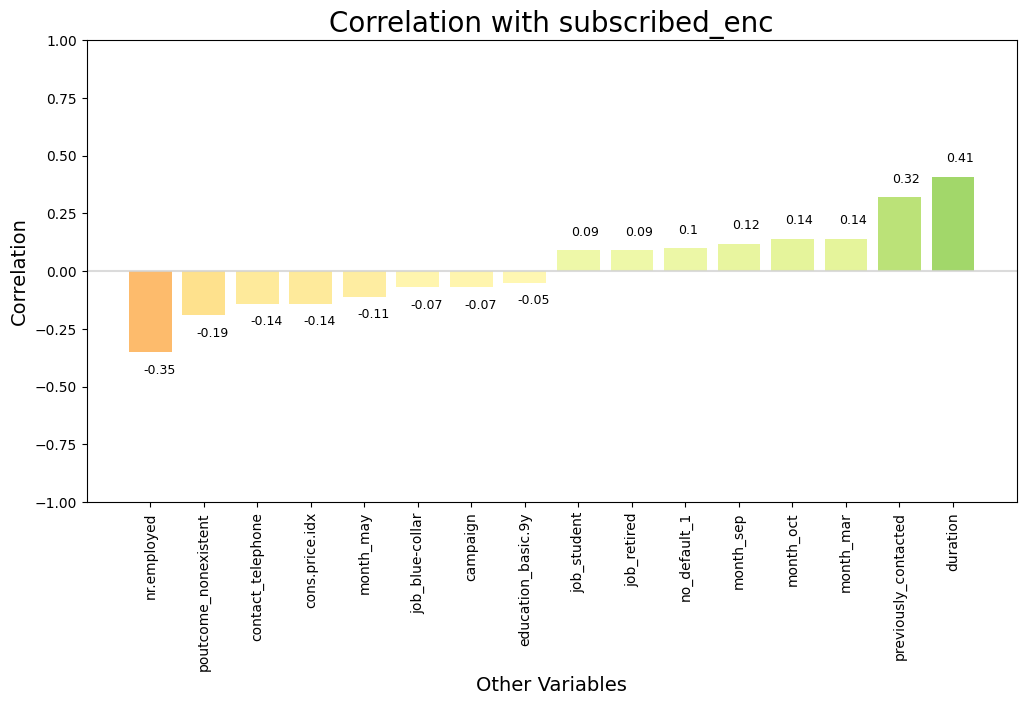

In [42]:
# Plot a chart showing the top correlations with target variable, but with redundant features removed
dw.plot_corr(df_reduced, 'subscribed_enc', n=16, size=(12,6), rotation=90)

---
## Tools

The `dw.tools` module provides helper tools used in data analysis, cleaning, and modeling.
It contains functions to detect for duplicates in lists.

* [Check for Duplicates](#Check-for-Duplicates) - *check_for_duplicates()*

### Check for Duplicates

`dw.check_for_duplicates()` checks for duplicate items (ex: column names) across multiple lists.

This function takes an arbitrary number of lists and checks for duplicate items
across the lists, as well as items appearing more than once within each list.
It prints a summary of the items and the lists they appear in. Additionally, if
a DataFrame is provided, it checks for any columns in the DataFrame that are
missing from the lists and prints them.

Use this function when you are organizing columns in a large DataFrame into
lists that represent their variable type (ex: num_columns, cat_columns). This
helps to ensure you haven't duplicated a column accidentally. And the optional
DataFrame check helps you identify columns that haven't been assigned to a list
yet. This is really useful when you're dealing with a large dataset.

In [43]:
# Scan the data we have in the dataframe
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,149.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,226.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,151.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,307.0,1.0,999.0,0.0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [44]:
# Review the dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             41188 non-null  float64 
 1   job             41188 non-null  category
 2   marital         41188 non-null  category
 3   education       41188 non-null  category
 4   default         41188 non-null  category
 5   housing         41188 non-null  category
 6   loan            41188 non-null  category
 7   contact         41188 non-null  category
 8   month           41188 non-null  category
 9   day_of_week     41188 non-null  category
 10  duration        41188 non-null  float64 
 11  campaign        41188 non-null  float64 
 12  pdays           41188 non-null  float64 
 13  previous        41188 non-null  float64 
 14  poutcome        41188 non-null  category
 15  emp.var.rate    41188 non-null  float64 
 16  cons.price.idx  41188 non-null  float64 
 17  cons.conf.id

In [45]:
# Review the number of unique values in each column
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

In [46]:
# Create column lists based on what we've learned for various variable types
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'previous', 'poutcome', 'y', 'y']
num_columns = ['age', 'duration', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [47]:
# Check for duplicate column names in the lists, since they were created manually
dw.check_for_duplicates(cat_columns, num_columns)

Items appearing in more than one list, or more than once per list:
previous (2): cat_columns, num_columns
y (2): cat_columns, cat_columns


In [48]:
# Fix the duplicates
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']

In [49]:
# Re-check duplicates, and also see if we missed any columns in the dataframe
dw.check_for_duplicates(cat_columns, num_columns, df=df)

Items appearing in more than one list, or more than once per list:
None.

Columns in the dataframe missing from the lists:
campaign


In [50]:
# Add the missing column to a list
num_columns.append('campaign')

In [51]:
# Final re-check
dw.check_for_duplicates(cat_columns, num_columns, df=df)

Items appearing in more than one list, or more than once per list:
None.

Columns in the dataframe missing from the lists:
None.
